In [1]:
%matplotlib inline
import sys
sys.path.append("../lib/")
import os
import string
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.tree import plot_tree
import seaborn as sns
import graphviz
import shap

from raman_lib.visualization import (plot_spectra_peaks, 
                                     plot_qc_summary, 
                                     plot_confidence_scores, 
                                     plot_coefs, 
                                     plot_confusion_matrix, 
                                     plot_roc_curve, 
                                     plot_validation_curve,
                                     plot_roc_comparison,
                                     boxplot_comparison)

# Setup

In [2]:
#dataset = "pro"
dataset = "L_540_2022_C_E_R_B"

In [3]:
results_path = Path("../results/") / dataset
img_path = Path("../img/") / dataset

img_path.mkdir(parents=True, exist_ok=True)

In [4]:
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))

y, y_key = pd.factorize(data.label)

In [5]:
rocs = {}
aucs = {}
p_vals = {}
accs = {}
f1_scores = {}
fit_times = {}
predict_times = {}

In [6]:
plt.style.use("seaborn-paper")
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.dpi"] = 100

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 11
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 9

# Quality Control

In [7]:
qc_results = pd.read_csv(results_path / (dataset + "_qc_scores.csv"))

qc_results.describe()

,Median Height,N Peaks
count,1501.000000,1501.000000
mean,683.982329,11.183877
std,706.340261,6.894406
min,0.000000,0.000000
25%,250.568102,5.000000
50%,469.613706,12.000000
75%,895.039220,16.000000
max,8645.508706,30.000000


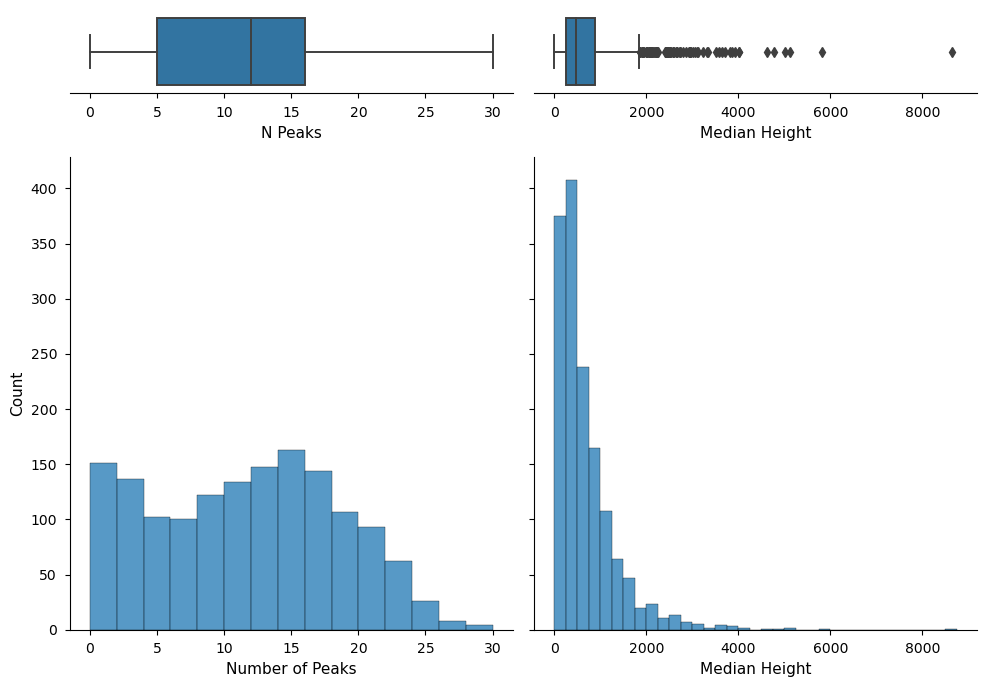

In [8]:
fig, ((ax_box1, ax_box2), (ax_hist1, ax_hist2)) = plt.subplots(
    2, 2, sharex="col", sharey="row", gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=qc_results.iloc[:,1], ax=ax_box1)
sns.boxplot(x=qc_results.iloc[:,0], ax=ax_box2)
sns.histplot(qc_results.iloc[:,1], ax=ax_hist1, binrange=None, binwidth=2)
sns.histplot(qc_results.iloc[:,0], ax=ax_hist2, binrange=None, binwidth=250)

ax_box1.set(yticks=[])
ax_box2.set(yticks=[])
sns.despine(ax=ax_hist1)
sns.despine(ax=ax_hist2)
sns.despine(ax=ax_box1, left=True)
sns.despine(ax=ax_box2, left=True)

ax_hist1.set_xlabel("Number of Peaks")
ax_hist2.set_xlabel(qc_results.columns[0])

#ax_hist1.set_ylim([None, ymax_peaks])
#ax_hist2.set_ylim([None, ymax_score])

ax_box1.tick_params(axis="x", labelbottom=True)
ax_box2.tick_params(axis="x", labelbottom=True)

fig.tight_layout()

# Dimensionality Reduction
## LDA

In [9]:
current_path = results_path / "lda_dim_reduction/lda/"
name = "LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.999469,0.406333,1.235527,0.003665,2.006230e-14
std,0.000320,0.010118,0.117733,0.000947,3.638871e-14
min,0.998750,0.391667,1.063437,0.002230,1.543010e-19
25%,0.999375,0.398750,1.154681,0.003043,1.471543e-16
50%,0.999479,0.405000,1.221585,0.003424,9.101349e-16
75%,0.999635,0.412500,1.303079,0.003998,1.726299e-14
max,1.000000,0.431667,1.471151,0.006163,1.252181e-13


In [10]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

AxisError: axis 1 is out of bounds for array of dimension 1

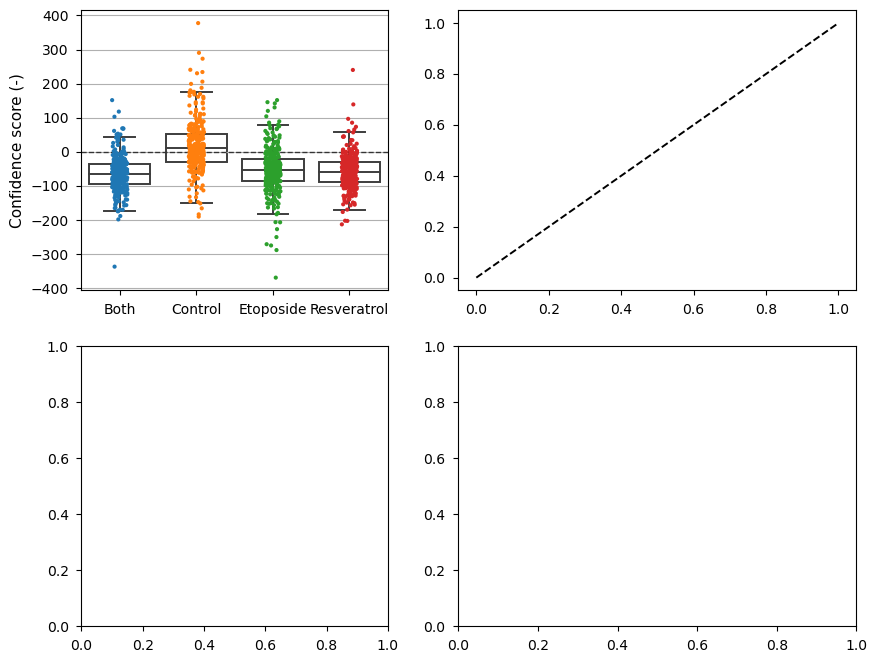

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8),
                        gridspec_kw={"width_ratios": (1, 1.3)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax2)
ax2.set_xlabel(f"False Positive Rate")
ax2.set_ylabel(f"True Positive Rate")
ax2.legend(loc="lower right")
ax2.grid()
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")

ax4 = axs[1,1]
plot_coefs(coef_df, ax=ax4)
ax4.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax4.set_ylabel("Coefficient (-)")
ax4.margins(x=0, y=0.2)
ax4.grid()
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.15, hspace=0.25)
fig.align_labels()

fig.savefig(img_path / "lda_combined.png", format="png", dpi=300, bbox_inches="tight")

## PCA-LDA

In [12]:
current_path = results_path / "lda_dim_reduction/pca_lda/"
name = "PCA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.653115,0.599375,3.507803,0.006122,3.440701e-56
std,0.004887,0.006987,0.137941,0.001163,1.491508e-55
min,0.640417,0.584167,3.366074,0.004855,3.452526e-63
25%,0.650833,0.593958,3.421842,0.005363,3.959216e-60
50%,0.653958,0.599583,3.473333,0.005908,4.249179e-59
75%,0.655990,0.604167,3.537029,0.006419,7.778936e-58
max,0.660208,0.612500,3.892665,0.009198,6.679880e-55


In [13]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

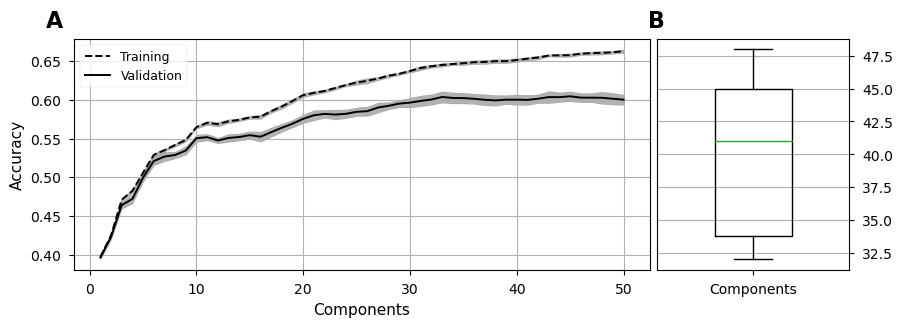

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Components")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Components"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "pcalda_validation.png", format="png", dpi=300, bbox_inches="tight")

AxisError: axis 1 is out of bounds for array of dimension 1

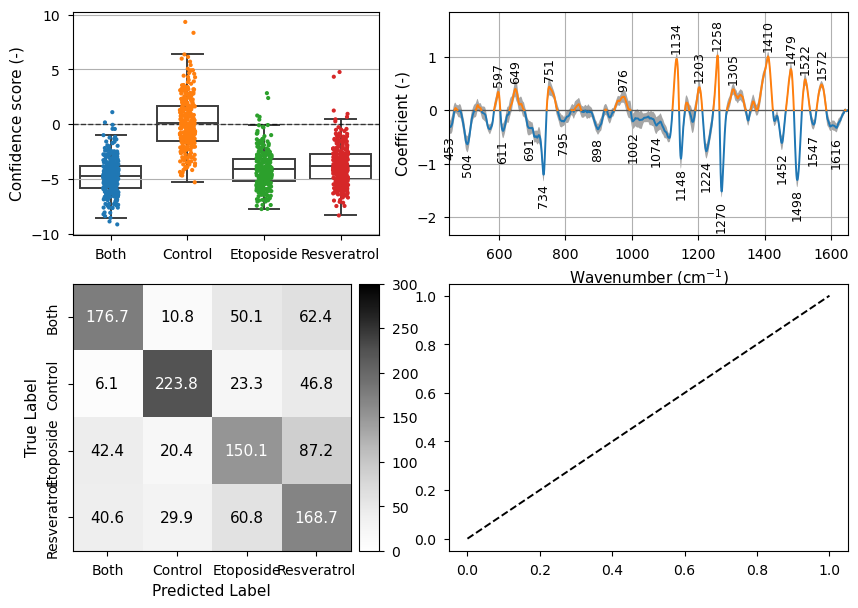

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 0.2, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "pcalda_combined.png", format="png", dpi=300, bbox_inches="tight")

## NMF-LDA

In [16]:
current_path = results_path / "lda_dim_reduction/nmf_lda/"
name = "NMF-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.641729,0.592583,4.596966,0.025542,3.866727e-55
std,0.004695,0.006466,0.166643,0.007771,1.150771e-54
min,0.630833,0.582500,4.329850,0.019394,3.891111e-61
25%,0.639583,0.589792,4.445852,0.021858,2.223965e-58
50%,0.642187,0.591250,4.632344,0.023864,2.719813e-57
75%,0.645469,0.595208,4.737302,0.025026,1.585133e-56
max,0.647917,0.606667,4.837175,0.055651,4.176936e-54


In [17]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

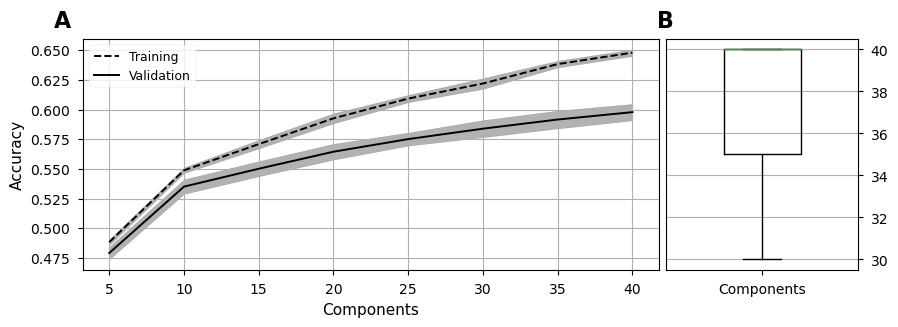

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Components")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Components"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "nmflda_validation.png", format="png", dpi=300, bbox_inches="tight")

AxisError: axis 1 is out of bounds for array of dimension 1

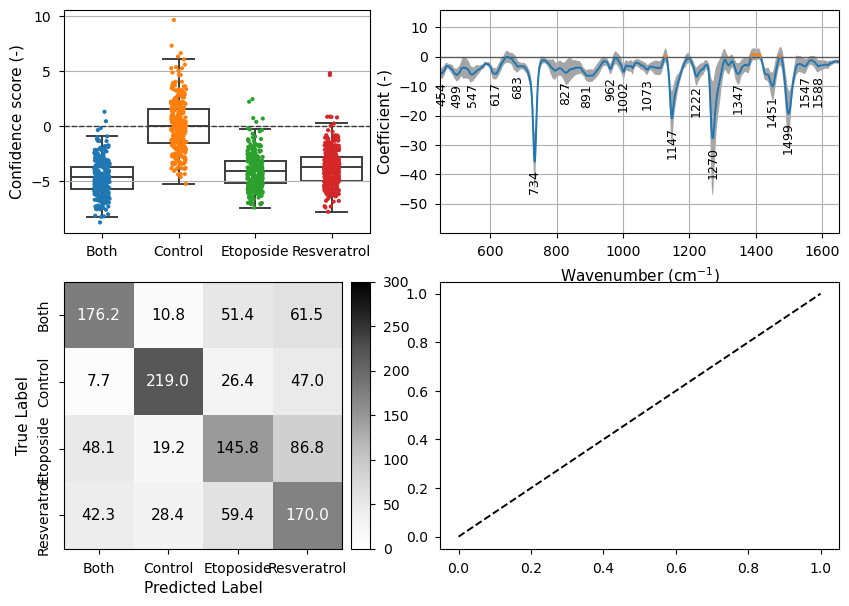

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 2.5, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "nmflda_combined.png", format="png", dpi=300, bbox_inches="tight")

## Feature Agglomeration (FA) - LDA

In [ ]:
current_path = results_path / "lda_dim_reduction/fa_lda/"
name = "FA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Clusters")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Clusters"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "falda_validation.png", format="png", dpi=300, bbox_inches="tight")

AxisError: axis 1 is out of bounds for array of dimension 1

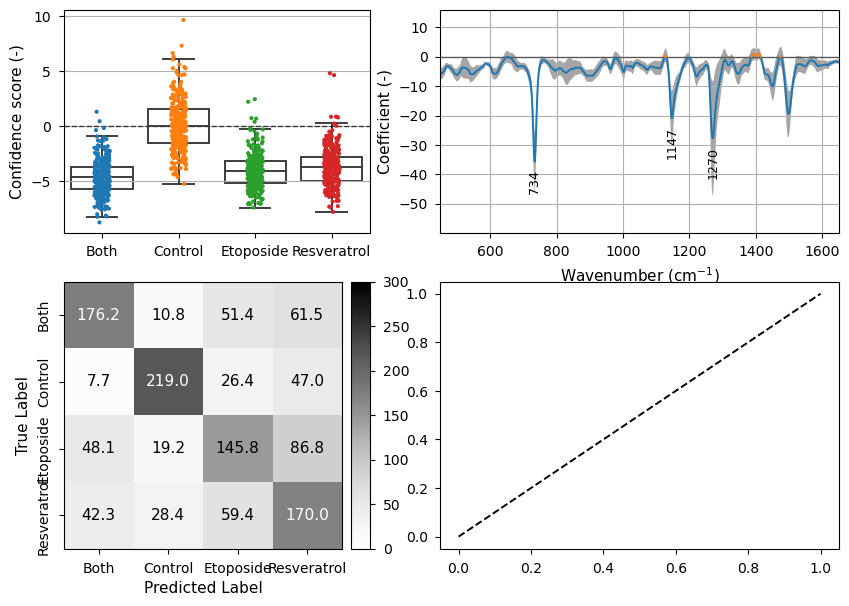

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 20, 
                                                                      "min_dist": 100,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "falda_combined.png", format="png", dpi=300, bbox_inches="tight")

## Peak-LDA

In [20]:
current_path = results_path / "lda_dim_reduction/peak_lda/"
name = "Peak-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

AttributeError: 'DataFrame' object has no attribute 'test_f1'

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Min. Peak Distance")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Distance"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "peaklda_validation.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 2.5, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "peaklda_combined.png", format="png", dpi=300, bbox_inches="tight")

## Comparison of LDA with different dimensionality Reductions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


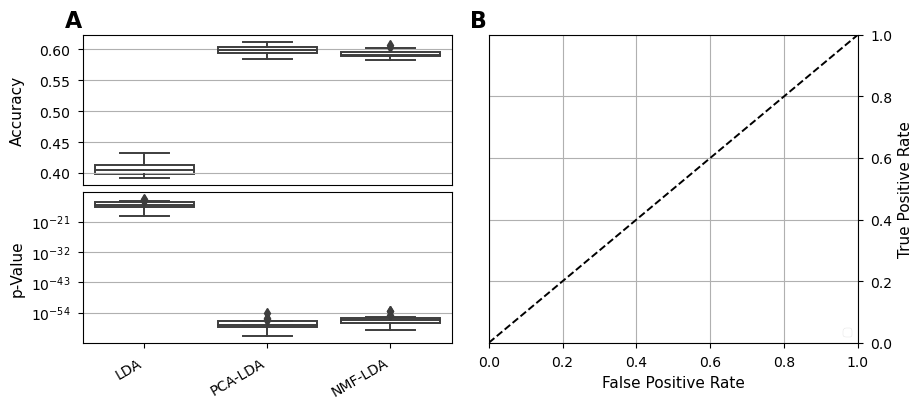

In [21]:
fig = plt.figure(figsize=(10,4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="LDA", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="LDA", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="LDA")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")
ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")
    
fig.align_ylabels()

fig.savefig(img_path / "lda_comparison.png", format="png", dpi=300, bbox_inches="tight")

# Regularized Models
## Logistic Regression (l1)

In [ ]:
current_path = results_path / "regularized_models/logreg_l1/"
name = "Log. Reg. (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "logreg_l1_validation.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 0.05, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.15)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "logreg_l1_combined.png", format="png", dpi=300, bbox_inches="tight")

## Logistic Regression (l2)

In [ ]:
current_path = results_path / "regularized_models/logreg_l2/"
name = "Log. Reg. (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "logreg_l2_validation.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True)
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.05)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "logreg_l2_combined.png", format="png", dpi=300, bbox_inches="tight")

## Support Vector Machine (l1)

In [ ]:
current_path = results_path / "regularized_models/svm_l1/"
name = "SVM (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "svm_l1_validation.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 0.05, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.15)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "svm_l1_combined.png", format="png", dpi=300, bbox_inches="tight")

## Support Vector Machine (l2)

In [ ]:
current_path = results_path / "regularized_models/svm_l2/"
name = "SVM (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "svm_l2_validation.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True)
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.05)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "svm_l2_combined.png", format="png", dpi=300, bbox_inches="tight")

## Comparison of Regularized Models (Logistic Regression and Linear SVM)

In [ ]:
fig = plt.figure(figsize=(10, 4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="Log. Reg.|SVM", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="Log. Reg.|SVM", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="Log. Reg.|SVM")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")
ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")
    
fig.align_ylabels()

fig.savefig(img_path / "linear_comparison.png", format="png", dpi=300, bbox_inches="tight")

# Tree-based Models
## Decision Tree

In [ ]:
current_path = results_path / "tree_based_models/decision_tree/"
name = "Decision Tree"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel(r"$\alpha$ (Pruning)")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels([r"$\alpha$ (Pruning)"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "tree_validation.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
tree = graphviz.Source.from_file(current_path / "tree.dot")
tree.render(img_path / "tree", format="png")
tree

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "tree_combined.png", format="png", dpi=300, bbox_inches="tight")

## Random Forest

In [ ]:
current_path = results_path / "tree_based_models/random_forest/"
name = "Random Forest"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

### XAI - shap
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)
shap_val_df = pd.DataFrame(data=np.absolute(shap_vals), columns=shap_features)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)
ax1.set_xlabel("Feature Subsample")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Feature Subsample"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "forest_validation.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(shap_val_df, ax=ax2, col=False, annotate=True, annot_kw={"min_height": 0.25, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})

ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Mean absolute SHAP value")
ax2.margins(x=0, y=0.2)
ax2.set_ylim(0, None)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "forest_combined.png", format="png", dpi=300, bbox_inches="tight")

### Explainable AI - SHAP

In [ ]:
fig, ax = plt.subplots()
first_expl = explanation[5]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

fig.savefig(img_path / "forest_shap_waterfall.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
plot_coefs(pd.Series(shap_vals[1,:], index=shap_features), ax=ax, annotate=True, annot_kw={"min_height": 0.5, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})
ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("SHAP value")
ax.margins(x=0, y=0.2)
ax.grid()

In [ ]:
fig, ax = plt.subplots()
shap.summary_plot(explanation, feature_names=shap_features, max_display=10)

fig.savefig(img_path / "forest_shap.png", format="png", dpi=300, bbox_inches="tight")

## Gradient Boosted Trees

In [ ]:
current_path = results_path / "tree_based_models/gbdt/"
name = "Gradient-boost"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

### XAI - shap
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)
shap_val_df = pd.Series(data=np.mean(np.absolute(shap_vals), axis=0), index=shap_features)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)
ax1.set_xlabel("Learning Rate")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Learning Rate"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "gbdt_validation.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(shap_val_df, ax=ax2, col=False, annotate=True, annot_kw={"min_height": 0.25, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})

ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Mean absolute SHAP value")
ax2.margins(x=0, y=0.2)
ax2.set_ylim(0, None)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "gbdt_combined.png", format="png", dpi=300, bbox_inches="tight")

### Explainable AI - SHAP

In [ ]:
fig, ax = plt.subplots()
first_expl = explanation[0]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

fig.savefig(img_path / "gbdt_shap_waterfall.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
plot_coefs(pd.Series(shap_vals[1,:], index=shap_features), ax=ax, annotate=True, annot_kw={"min_height": 0.1, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})
ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("SHAP value")
ax.margins(x=0, y=0.2)
ax.grid()

In [ ]:
fig, ax = plt.subplots()
shap.summary_plot(explanation, feature_names=shap_features, max_display=10)

fig.savefig(img_path / "gbdt_shap.png", format="png", dpi=300, bbox_inches="tight")

## Comparison of Tree-based Models

In [ ]:
fig = plt.figure(figsize=(10, 4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="Tree|Forest|Gradient", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="Tree|Forest|Gradient", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="Tree|Forest|Gradient")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")
ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")

fig.align_ylabels()

fig.savefig(img_path / "tree_comparison.png", format="png", dpi=300, bbox_inches="tight")

## Overall Comparison

In [ ]:
fig = plt.figure(figsize=(10, 4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")
ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")

fig.align_ylabels()

fig.savefig(img_path / "all_comparison.png", format="png", dpi=300, bbox_inches="tight")